# Evaluating Model Performance on Rating Downgrades and Ensembling
Last Updated by Developer 15/8/2023

This notebook looks at creating ensemble models to improve model performance. Several ideas are tested here: 
1. Ensembles using models with different optimization procedures, architectures and features
2. Ensembles using models with same optimization, architecture and features 
    - Dropout of 0.1 vs 0.25 is compared for these similar models 
3. Efficient architecture for ensembles that are conducive to deploying in production on Vertex AI 
4. Optimal ensemble since and ensemble performance on different segments of muni market 

Note to self, these are the current conditions for applying the dollar price model in production: 
- any null yields in the trade history 
- negative yields 
- If the most recent trade is later than 8-4-2021, than use the YS model but remove all trades prior to 8-4-2021 in the trades history
- If the most recent trade is prior to 8-4-2021, than use the dollar price model.   Display yield if within the expected range., 1.5-7%.  We need to think of a message to display when outside of the range.

## Load packages, data

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc
import os

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

from ficc.utils.auxiliary_functions import sqltodf
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-08-14 17:57:14.246177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 17:57:14.420052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-14 17:57:14.422195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-01-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = 0.1 #ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.1 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 
trade_history_col = 'trade_history_shortened'

In [3]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [4]:
%time processed_data = load_data_from_pickle('processed_data_2023-07-24-14:53.pkl', 'ficc_training_data_latest')

File available, loading pickle
CPU times: user 15.7 s, sys: 8.12 s, total: 23.8 s
Wall time: 56.6 s


In [5]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [6]:
processed_data.reset_index(drop=True, inplace=True)
processed_data.sort_values('trade_datetime', inplace=True)

In [7]:
def process_data(data): 
    # data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    data.purpose_sub_class.fillna(0, inplace=True)
    
    return data

In [8]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    diff = 10**trade[2] - 10**row.quantity
    quantity_diff = np.sign(diff) * np.log10(1 + np.abs(diff))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [9]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 1min 50s, sys: 18.2 s, total: 2min 8s
Wall time: 4min 7s


In [10]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

CPU times: user 959 ms, sys: 104 ms, total: 1.06 s
Wall time: 1.12 s


In [11]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 36.8 s, sys: 15.2 s, total: 52 s
Wall time: 57.1 s


In [12]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)

In [13]:
%%time 
processed_data = process_data(processed_data)

CPU times: user 45.9 s, sys: 16.9 s, total: 1min 2s
Wall time: 1min 7s


In [14]:
processed_data['moodys_rating'] = processed_data.moodys_long.fillna('NR')
processed_data['ratings_concat'] = processed_data['rating'] + processed_data['moodys_rating']

In [15]:
def modify_features(cols, how, where=None):
    #function to conveniently add or subtract features from the global feature lists 
    
    global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
    if how not in ['add','remove']:
        raise ValueError(f"'how' argument must be one off the following: {['add','remove']}")
        
    if where and where not in ['categorical','binary', 'numeric']:
        raise ValueError(f"'where' argument must be one off the following: {['categorical','binary', 'numeric']}")
    
    if how == 'remove':
        for col in cols: 
            if col in CATEGORICAL_FEATURES:
                CATEGORICAL_FEATURES.remove(col)
            if col in BINARY:
                BINARY.remove(col)
            if col in NON_CAT_FEATURES:
                NON_CAT_FEATURES.remove(col)
            if col in PREDICTORS:
                PREDICTORS.remove(col)
            
    if how == 'add':
        for col in cols: 
            if col not in CATEGORICAL_FEATURES and where=='categorical':
                CATEGORICAL_FEATURES.append(col)
            if col not in BINARY and where=='binary':
                BINARY.append(col)
            if col not in NON_CAT_FEATURES and where=='numeric':
                NON_CAT_FEATURES.append(col)
            if col not in PREDICTORS:
                PREDICTORS.append(col)

In [16]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

#add for the encoders, then remove later if needed 
modify_features(['rating','moodys_rating', 'ratings_concat'], how = 'add', where='categorical')   
    
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
# with open('encoders.pkl','wb') as file:
#     pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes
moodys_rating
ratings_concat


In [17]:
%%time
TRADE_SEQUENCE_LENGTH = 5 
processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 2.35 s, sys: 13.7 ms, total: 2.37 s
Wall time: 2.37 s


In [18]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

In [19]:
# %time processed_data.to_csv('processed_data_final.csv')

In [20]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-01-03 00:00:00, end: 2023-05-31 00:00:00
Test data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00


In [21]:
len(train_dataframe), len(test_dataframe)

(3360391, 720563)

#### Adding rating upgrades and downgrades

In [26]:
# QUERY = '''
# SELECT rtrs_control_number, cusip, rating_upgrade,rating_downgrade,rating_downgrade_to_junk 
# FROM `eng-reactor-287421.auxiliary_views.materialized_trade_history` 
# WHERE trade_datetime>='2023-01-01' AND trade_datetime<='2023-06-30' 
# '''
# ratings_df = sqltodf(QUERY, bq_client)

In [27]:
# #find all cusips which have a rather downgrade AND upgrade at some point 
# upgrade_and_downgrade = ratings_df.groupby('cusip')[['rating_upgrade', 'rating_downgrade']].apply(lambda x: x.any(axis=0).values.all())

In [28]:
# upgrade_and_downgrade_cusips = upgrade_and_downgrade[upgrade_and_downgrade].index.values

In [141]:
# len(test_dataframe.set_index('rtrs_control_number')\
# .join(ratings_df[['rtrs_control_number', 'rating_upgrade','rating_downgrade','rating_downgrade_to_junk']].set_index('rtrs_control_number'), \
#       on='rtrs_control_number',
#      how='left'))

727225

## Ensembling Different Models: 

In [350]:
## MODELS WITHOUT MOODYS 
#same as production 
baseline_model = keras.models.load_model('large_model_baseline_dropout0.1_final/') 
#bottleneck architecture
new_model = keras.models.load_model('large_model_bottleneck1_dropout0.1_final/')

## MODELS WITH MOODYS 
#same as production + Moodys as a feature 
baseline_model_moodys = keras.models.load_model('large_model_baseline_moodys_dropout0.1_final/')
#bottleneck architecture + Moodys as a feature 
new_model_moodys = keras.models.load_model('large_model_bottleneck1_moodys_dropout0.1_final/')

In [29]:
def create_input(df, moodys = False):
    #create input for regular NN 
    global encoders
    datalist = []
    
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        if not moodys: #simple if statement to remove moodys if we dont want it 
            if f == 'moodys_rating':
                continue
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def create_input_pretrained(df, moodys = False):
    #create input for pretrained network, which takes two different lists since the ref and trade history model are separate 
    global encoders
    trade_history_input = []
    reference_input = []
        
    trade_history_input.append(np.stack(df[trade_history_col].to_numpy()))
    trade_history_input.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    reference_input.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        if not moodys: #simple if statement to remove moodys if we dont want it 
            if f == 'moodys_rating':
                continue
        encoded = encoders[f].transform(df[f])
        reference_input.append(encoded.astype('float32'))
    
    return trade_history_input, reference_input

In [397]:
# CATEGORICAL_FEATURES = ['rating',
#  'incorporated_state_code',
#  'trade_type',
#  'purpose_class',
#  'max_ys_ttypes',
#  'min_ys_ttypes',
#  'max_qty_ttypes',
#  'min_ago_ttypes',
#  'D_min_ago_ttypes',
#  'P_min_ago_ttypes',
#  'S_min_ago_ttypes']

In [361]:
#this just adds and removes the ratings features from CATEGORICAL_FEATURES 
#NOTE: order of features in CATEGORICAL_FEATURES has to align with the models inputs at training, otherwise we will get funky predictions 
modify_features(['moodys_rating', 'ratings_concat'], how = 'remove')   
modify_features(['rating'], how = 'add', where='categorical') 
x_test = create_input(test_dataframe, moodys = False)

modify_features(['rating', 'moodys_rating'], how = 'add', where='categorical') 
x_test_moodys = create_input(test_dataframe, moodys = True)
trade_history_x_test_moodys, reference_x_test_moodys = create_input_pretrained(test_dataframe, moodys = True)

In [34]:
# processed_data['ratings_concat'] = processed_data['rating'] + processed_data['moodys_rating']

In [362]:
# #add the ratings_concat feature for the ensemble with 4 of the same models; those just happened to be on hand to test ensembling
# modify_features(['rating', 'moodys_rating'], how = 'remove')
# modify_features(['ratings_concat'], how = 'add', where='categorical') 
# x_test_ratings_concat = create_input(test_dataframe)
# x_train_ratings_concat = create_input(train_dataframe)
# CATEGORICAL_FEATURES

In [363]:
print(len(x_test))
print(len(x_test_moodys))

14
15


In [364]:
y_test = test_dataframe[target_variable]  
  
%time test_dataframe['baseline_prediction'] = baseline_model.predict(x_test, batch_size=5024)
%time test_dataframe['bottleneck_prediction'] = new_model.predict(x_test, batch_size=5024)

%time test_dataframe['baseline_prediction_moodys'] = baseline_model_moodys.predict(x_test_moodys, batch_size=5024)
%time test_dataframe['bottleneck_prediction_moodys'] = new_model_moodys.predict(x_test_moodys, batch_size=5024)

CPU times: user 2.43 s, sys: 438 ms, total: 2.87 s
Wall time: 2 s
CPU times: user 2.16 s, sys: 570 ms, total: 2.73 s
Wall time: 1.84 s
CPU times: user 2.21 s, sys: 642 ms, total: 2.85 s
Wall time: 1.93 s
CPU times: user 2.18 s, sys: 539 ms, total: 2.72 s
Wall time: 1.84 s


In [365]:
# bottleneck architecture with pretraining of reference model and trade history model by 75 and 5 epochs respectively, then fine-tuning of 25 epochs 
new_model_moodys_pretrained = keras.models.load_model('large_model_pretrained_combined_model_final/')

In [366]:
%time test_dataframe['pretrained_prediction_moodys'] = new_model_moodys_pretrained.predict([trade_history_x_test_moodys, reference_x_test_moodys], batch_size=5024)

2023-08-15 19:10:43.386380: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


CPU times: user 3.69 s, sys: 570 ms, total: 4.26 s
Wall time: 3.36 s


First we look at the MAE of each individual model 

In [29]:
prediction_cols = ['baseline_prediction','bottleneck_prediction', 'baseline_prediction_moodys', 'bottleneck_prediction_moodys', 'pretrained_prediction_moodys']
error_cols = [col+'_error' for col in prediction_cols]
for col in prediction_cols: 
    test_dataframe[col+'_error'] = test_dataframe.new_ys - test_dataframe[col]
    print(f'{col:30}: {mean_absolute_error(test_dataframe.new_ys, test_dataframe[col]):.3f}')

baseline_prediction           : 8.102
bottleneck_prediction         : 8.073
baseline_prediction_moodys    : 8.077
bottleneck_prediction_moodys  : 8.050
pretrained_prediction_moodys  : 8.006


**Defining volatility and disagreement:**

We want some way to identify and summarize how these models are different from one another in predictions
 - disagreement defined as the max range of predicted yields for a given trade 
 - volatility defined as the standard deviation in predicted yields for a given trade 
 
The point of these is to see how the different models differ in their predictions for individual trades. Even where the model MAE is similar, it does not mean that it is uniformly similar across all trades - this helps us to identify the trades where the models differ the most/least

In [400]:
disagreement = test_dataframe[prediction_cols].parallel_apply(lambda x: abs(x.max() - x.min()), axis=1)
volatility = test_dataframe[prediction_cols].parallel_apply(lambda x: x.std(), axis=1)
test_dataframe['disagreement'] = disagreement 
test_dataframe['volatility'] = volatility 

In [382]:
def top_bottom_K(df, top_K, last_K, col = 'disagreement', prediction_cols=prediction_cols):
    #summarizes disagreement/volatility and returns specified number of trades with the highest/lowest disagreement/volatility 
    
    df.sort_values(by=col, ascending=False, inplace=True)
    
    top_K_cusip, bottom_K_cusip = [], []
    
    if top_K:
        top_K_cusip = df.head(top_K)
        
    if last_K:
        bottom_K_cusip = df.tail(last_K)
        
    mean = df[col].mean()
    median = df[col].median()
    std = df[col].std() 
    MAX = df[col].max() 
    MIN = df[col].min() 
    percentile_95 = df[col].quantile(.95)
    percentile_67 = df[col].quantile(.67)
    percentile_33 = df[col].quantile(.33)
    percentile_5 =df[col].quantile(.5)
    
    print(f'{"SUMMARY:":=^50}')
    print(f'{"MEAN:":10}{mean:.2f}; {"MEDIAN:":10}{median:.2f}; {"STD:":10}{std:.2f}')
    print()
    print(f'{"PERCENTILES:":=^50}')
    print(f'{"5%:":10}{percentile_5:.2f}; {"33%:":10}{percentile_33:.2F}; {"67%:":10}{percentile_67:.2F}; {"95%:":10}{percentile_95:.2F}')
    print(f'{"MAX:":9}{MAX:.2f}; {"MIN:":9}{MIN:.2f}')
    
    print()
    print(f'TOP 10 TRADES WITH BIGGEST {col.upper()}')
    display(test_dataframe[['rtrs_control_number', 'cusip','trade_datetime', 'new_ys'] + prediction_cols].iloc[:10])
    print(f'TOP 10 TRADES WITH SMALLEST {col.upper()}')
    display(test_dataframe[['rtrs_control_number', 'cusip','trade_datetime', 'new_ys'] + prediction_cols].iloc[-10:])
    
    
    return top_K_cusip, bottom_K_cusip

In [129]:
#Worth noting how stark the difference in predictions can be for the trades with large disagreement. Also worth noting that they generally have high yields anyway.
#If we look at the averages, on average we have a volatility of 2.42bps for a trade, which is actually quite small - models are generally in agreement for MOST trades 

top_K_volatility, bottom_K_volatility = top_bottom_K(test_dataframe, 
                                                                    1000, 
                                                                    1000,
                                                                    col='volatility',
                                                                    prediction_cols=prediction_cols)

=====================SUMMARY:=====================
MEAN:     2.42; MEDIAN:   1.75; STD:      3.45

===================PERCENTILES:===================
5%:       1.75; 33%:      1.26; 67%:      2.45; 95%:      6.34
MAX:     654.22; MIN:     0.03

TOP 10 TRADES WITH BIGGEST VOLATILITY


,rtrs_control_number,cusip,trade_datetime,new_ys,baseline_prediction,bottleneck_prediction,baseline_prediction_moodys,bottleneck_prediction_moodys,pretrained_prediction_moodys
653553,2023062804369300,08451PAD3,2023-06-28 12:03:35,1495.366,1845.187,2201.431,2699.236,951.359,1604.460
653555,2023062804362100,08451PAD3,2023-06-28 12:03:35,1485.566,1782.980,2167.510,2664.763,946.754,1614.118
32517,2023060106710600,08451PAE1,2023-06-01 12:38:11,2967.602,1945.152,2240.073,2770.417,1105.083,1945.819
22724,2023060103442300,08451PAE1,2023-06-01 10:57:33,2990.911,1783.335,2163.400,2627.344,1011.989,1928.210
475434,2023062100936900,08451PAF8,2023-06-21 09:40:21,1078.953,1706.325,1822.709,2113.273,950.912,1362.817
475432,2023062100943200,08451PAF8,2023-06-21 09:40:21,1091.953,1706.325,1822.709,2113.273,950.912,1362.817
475433,2023062100948600,08451PAF8,2023-06-21 09:40:21,1080.653,1706.325,1822.709,2113.273,950.912,1362.817
475431,2023062100936300,08451PAF8,2023-06-21 09:40:21,1010.753,1645.501,1785.673,2098.000,980.994,1379.177
646040,2023062800974600,08451PAF8,2023-06-28 09:44:11,1088.548,1242.365,1429.804,1108.993,1009.244,553.783
646049,2023062800996500,08451PAF8,2023-06-28 09:44:11,1087.348,1192.253,1371.202,1088.724,957.724,519.676


TOP 10 TRADES WITH SMALLEST VOLATILITY


,rtrs_control_number,cusip,trade_datetime,new_ys,baseline_prediction,bottleneck_prediction,baseline_prediction_moodys,bottleneck_prediction_moodys,pretrained_prediction_moodys
214826,2023060803266400,622792PF0,2023-06-08 11:14:40,36.134,36.291,36.291,36.355,36.324,36.228
224358,2023060908299400,508444EP7,2023-06-09 15:39:52,16.884,16.587,16.544,16.460,16.532,16.519
716681,2023063004435200,467578LZ1,2023-06-30 12:03:40,9.095,9.255,9.242,9.190,9.271,9.164
716684,2023063004440800,467578LZ1,2023-06-30 12:03:40,9.495,9.255,9.242,9.190,9.271,9.164
544258,2023062300887000,97705MPF6,2023-06-23 09:38:19,-5.430,-2.300,-2.351,-2.369,-2.399,-2.303
40407,2023060207888600,097437RY5,2023-06-02 13:44:28,16.077,16.462,16.461,16.490,16.561,16.481
160605,2023060709426200,6133498P7,2023-06-07 14:48:35,150.739,150.972,150.974,150.916,150.965,151.007
160595,2023060709497500,6133498P7,2023-06-07 14:48:35,150.739,150.972,150.974,150.916,150.965,151.007
160594,2023060709392900,6133498P7,2023-06-07 14:48:35,150.739,150.972,150.974,150.916,150.965,151.007
49324,2023060210432900,525516FC9,2023-06-02 15:26:13,16.671,16.515,16.440,16.501,16.471,16.474


In [401]:
top_K_disagreement, bottom_K_disagreement = top_bottom_K(test_dataframe, 
                                                                    1000, 
                                                                    1000,
                                                                    col='disagreement',
                                                                    prediction_cols=prediction_cols)

=====================SUMMARY:=====================
MEAN:     5.97; MEDIAN:   4.32; STD:      8.73

===================PERCENTILES:===================
5%:       4.32; 33%:      3.09; 67%:      6.04; 95%:      15.73
MAX:     1747.88; MIN:     0.08

TOP 10 TRADES WITH BIGGEST DISAGREEMENT


,rtrs_control_number,cusip,trade_datetime,new_ys,baseline_prediction,bottleneck_prediction,baseline_prediction_moodys,bottleneck_prediction_moodys,pretrained_prediction_moodys
653553,2023062804369300,08451PAD3,2023-06-28 12:03:35,1495.366,1845.186,2201.431,2699.237,951.361,1604.460
653555,2023062804362100,08451PAD3,2023-06-28 12:03:35,1485.566,1782.980,2167.511,2664.764,946.754,1614.119
32517,2023060106710600,08451PAE1,2023-06-01 12:38:11,2967.602,1945.152,2240.075,2770.418,1105.084,1945.822
22724,2023060103442300,08451PAE1,2023-06-01 10:57:33,2990.911,1783.336,2163.401,2627.343,1011.990,1928.210
475433,2023062100948600,08451PAF8,2023-06-21 09:40:21,1080.653,1706.324,1822.709,2113.274,950.912,1362.818
475434,2023062100936900,08451PAF8,2023-06-21 09:40:21,1078.953,1706.324,1822.709,2113.274,950.912,1362.818
475432,2023062100943200,08451PAF8,2023-06-21 09:40:21,1091.953,1706.324,1822.709,2113.274,950.912,1362.818
475431,2023062100936300,08451PAF8,2023-06-21 09:40:21,1010.753,1645.501,1785.673,2098.000,980.994,1379.177
646040,2023062800974600,08451PAF8,2023-06-28 09:44:11,1088.548,1242.366,1429.803,1108.993,1009.243,553.783
646049,2023062800996500,08451PAF8,2023-06-28 09:44:11,1087.348,1192.253,1371.202,1088.725,957.724,519.676


TOP 10 TRADES WITH SMALLEST DISAGREEMENT


,rtrs_control_number,cusip,trade_datetime,new_ys,baseline_prediction,bottleneck_prediction,baseline_prediction_moodys,bottleneck_prediction_moodys,pretrained_prediction_moodys
214826,2023060803266400,622792PF0,2023-06-08 11:14:40,36.134,36.291,36.291,36.355,36.324,36.228
369310,2023061511596300,414009QX1,2023-06-15 16:19:55,9.321,9.429,9.509,9.427,9.403,9.518
716684,2023063004440800,467578LZ1,2023-06-30 12:03:40,9.495,9.255,9.242,9.190,9.271,9.164
716681,2023063004435200,467578LZ1,2023-06-30 12:03:40,9.095,9.255,9.242,9.190,9.271,9.164
40407,2023060207888600,097437RY5,2023-06-02 13:44:28,16.077,16.462,16.461,16.490,16.561,16.481
544258,2023062300887000,97705MPF6,2023-06-23 09:38:19,-5.430,-2.300,-2.351,-2.369,-2.399,-2.303
160594,2023060709392900,6133498P7,2023-06-07 14:48:35,150.739,150.972,150.974,150.916,150.965,151.007
160595,2023060709497500,6133498P7,2023-06-07 14:48:35,150.739,150.972,150.974,150.916,150.965,151.007
160605,2023060709426200,6133498P7,2023-06-07 14:48:35,150.739,150.972,150.974,150.916,150.965,151.007
49324,2023060210432900,525516FC9,2023-06-02 15:26:13,16.671,16.515,16.439,16.501,16.471,16.474


**Correlation between disagreement/volatility and errors:**

If volatility and disagreement is high, it is reasonable to think that error will be higher too - these are bonds that are difficult to predict, so different models have vastly different answers, and hence our predictions are more probably wrong. The summary reveals that this correlation only exists for trades with higher volatilities/disagreement to begin with. For now this insight is interesting but not particularly useful, I think.

In [131]:
vol_extremes_10_90 = ((test_dataframe.volatility <= test_dataframe.volatility.quantile(.10)) | (test_dataframe.volatility >= test_dataframe.volatility.quantile(.90)))
disagreement_extremess_10_90 = ((test_dataframe.disagreement <= test_dataframe.disagreement.quantile(.10)) | (test_dataframe.disagreement >= test_dataframe.disagreement.quantile(.90)))

vol_extremes_1_99 = ((test_dataframe.volatility <= test_dataframe.volatility.quantile(.1)) | (test_dataframe.volatility >= test_dataframe.volatility.quantile(.99)))
disagreement_extremess_1_99 = ((test_dataframe.disagreement <= test_dataframe.disagreement.quantile(.1)) | (test_dataframe.disagreement >= test_dataframe.disagreement.quantile(.99)))

display(test_dataframe[error_cols+['volatility','disagreement']].corr()[['volatility','disagreement']].drop(['volatility','disagreement']))
display(test_dataframe[vol_extremes_10_90 & disagreement_extremess_10_90][error_cols+['volatility','disagreement']].corr()[['volatility','disagreement']].drop(['volatility','disagreement']))
display(test_dataframe[vol_extremes_1_99 & disagreement_extremess_1_99][error_cols+['volatility','disagreement']].corr()[['volatility','disagreement']].drop(['volatility','disagreement']))

,volatility,disagreement
baseline_prediction_error,-0.025,-0.022
bottleneck_prediction_error,-0.078,-0.077
baseline_prediction_moodys_error,-0.171,-0.172
bottleneck_prediction_moodys_error,0.029,0.041
pretrained_prediction_moodys_error,-0.003,0.002


,volatility,disagreement
baseline_prediction_error,-0.023,-0.018
bottleneck_prediction_error,-0.109,-0.107
baseline_prediction_moodys_error,-0.244,-0.245
bottleneck_prediction_moodys_error,0.073,0.090
pretrained_prediction_moodys_error,0.020,0.027


,volatility,disagreement
baseline_prediction_error,-0.017,-0.009
bottleneck_prediction_error,-0.166,-0.161
baseline_prediction_moodys_error,-0.370,-0.371
bottleneck_prediction_moodys_error,0.143,0.168
pretrained_prediction_moodys_error,0.063,0.074


In [132]:
summary = pd.concat([test_dataframe[test_dataframe.rtrs_control_number.isin(top_K_disagreement.rtrs_control_number)][error_cols].mean(),
            test_dataframe[test_dataframe.rtrs_control_number.isin(bottom_K_disagreement.rtrs_control_number)][error_cols].mean(),
            test_dataframe[test_dataframe.rtrs_control_number.isin(top_K_volatility.rtrs_control_number)][error_cols].mean(),
            test_dataframe[test_dataframe.rtrs_control_number.isin(bottom_K_volatility.rtrs_control_number)][error_cols].mean()],
          axis = 1)
summary.columns = ['top_K_disagreement', 'bottom_K_disagreement', 'top_K_volatility', 'bottom_K_volatility']
summary

,top_K_disagreement,bottom_K_disagreement,top_K_volatility,bottom_K_volatility
baseline_prediction_error,-1.525,-0.270,-1.652,-0.253
bottleneck_prediction_error,-11.576,-0.220,-11.290,-0.212
baseline_prediction_moodys_error,-21.061,-0.273,-21.060,-0.259
bottleneck_prediction_moodys_error,-11.627,-0.285,-10.671,-0.278
pretrained_prediction_moodys_error,-9.481,-0.239,-8.711,-0.227


In [133]:
test_dataframe[error_cols].agg([lambda x: abs(x).mean(),'std']).rename({'<lambda>':'mean'})

,baseline_prediction_error,bottleneck_prediction_error,baseline_prediction_moodys_error,bottleneck_prediction_moodys_error,pretrained_prediction_moodys_error
mean,8.102,8.073,8.077,8.050,8.006
std,13.864,13.982,14.010,14.306,13.851


In [159]:
test_dataframe[error_cols].corr()

,baseline_prediction_error,bottleneck_prediction_error,baseline_prediction_moodys_error,bottleneck_prediction_moodys_error,pretrained_prediction_moodys_error
baseline_prediction_error,1.000,0.928,0.919,0.903,0.922
bottleneck_prediction_error,0.928,1.000,0.907,0.914,0.927
baseline_prediction_moodys_error,0.919,0.907,1.000,0.854,0.899
bottleneck_prediction_moodys_error,0.903,0.914,0.854,1.000,0.927
pretrained_prediction_moodys_error,0.922,0.927,0.899,0.927,1.000


In [394]:
test_dataframe[['last_yield','volatility','disagreement']].corr()

,last_yield,volatility,disagreement
last_yield,1.000,0.178,0.180
volatility,0.178,1.000,0.996
disagreement,0.180,0.996,1.000


In [238]:
prediction_cols = ['baseline_prediction','bottleneck_prediction', 'baseline_prediction_moodys', 'bottleneck_prediction_moodys', 'pretrained_prediction_moodys']
error_cols = [col+'_error' for col in prediction_cols]
for col in prediction_cols: 
    test_dataframe[col+'_error'] = test_dataframe.new_ys - test_dataframe[col]
    print(f'{col:30}: {mean_absolute_error(test_dataframe.new_ys, test_dataframe[col]):.3f}')
print(f'{"COMBINED AVG PREDICTION":30}: {mean_absolute_error(test_dataframe[prediction_cols].mean(axis=1), test_dataframe.new_ys):.3f}')

baseline_prediction           : 8.102
bottleneck_prediction         : 8.073
baseline_prediction_moodys    : 8.077
bottleneck_prediction_moodys  : 8.050
pretrained_prediction_moodys  : 8.006
COMBINED AVG PREDICTION       : 7.812


In [158]:
for col in error_cols:
    print(f'{col:35}: {test_dataframe[error_cols].corr()[col].drop(col).mean():.3f}')

baseline_prediction_error          : 0.918
bottleneck_prediction_error        : 0.919
baseline_prediction_moodys_error   : 0.895
bottleneck_prediction_moodys_error : 0.900
pretrained_prediction_moodys_error : 0.919


### Understanding why ensembles help:

This section looks at how performance improves with ensemble size and where these benefits are greatest:

In [44]:
def find_combinations(path, rem, k):
    #simple dfs to find permutations 
    if k == 0:
        combinations.append(path)
        return 
    else: 
        for i in range(len(rem)):
            find_combinations(path+[rem[i]], rem[i+1:], k-1)

In [372]:
display(ensemble_candidates[ensemble_candidates.ensemble_size==2].sort_values('mae'))
print(ensemble_candidates[ensemble_candidates.ensemble_size==2].mae.max() - ensemble_candidates[ensemble_candidates.ensemble_size==2].mae.min())

,ensemble_size,mae,combination
13,2.000,7.878,"[baseline_prediction_moodys, pretrained_predic..."
8,2.000,7.883,"[baseline_prediction, pretrained_prediction_mo..."
9,2.000,7.901,"[bottleneck_prediction, baseline_prediction_mo..."
12,2.000,7.903,"[baseline_prediction_moodys, bottleneck_predic..."
14,2.000,7.908,"[bottleneck_prediction_moodys, pretrained_pred..."
11,2.000,7.908,"[bottleneck_prediction, pretrained_prediction_..."
7,2.000,7.910,"[baseline_prediction, bottleneck_prediction_mo..."
5,2.000,7.927,"[baseline_prediction, bottleneck_prediction]"
6,2.000,7.932,"[baseline_prediction, baseline_prediction_moodys]"
10,2.000,7.935,"[bottleneck_prediction, bottleneck_prediction_..."


0.05721899375315953


===============================================TOP 5================================================


,ensemble_size,mae,combination
30,5.000,7.812,"[baseline_prediction, bottleneck_prediction, b..."
28,4.000,7.820,"[baseline_prediction, baseline_prediction_mood..."
26,4.000,7.821,"[baseline_prediction, bottleneck_prediction, b..."
29,4.000,7.830,"[bottleneck_prediction, baseline_prediction_mo..."
27,4.000,7.836,"[baseline_prediction, bottleneck_prediction, b..."



==============================================BOTTOM 5==============================================


,ensemble_size,mae,combination
4,1.000,8.006,[pretrained_prediction_moodys]
3,1.000,8.050,[bottleneck_prediction_moodys]
1,1.000,8.073,[bottleneck_prediction]
2,1.000,8.077,[baseline_prediction_moodys]
0,1.000,8.102,[baseline_prediction]


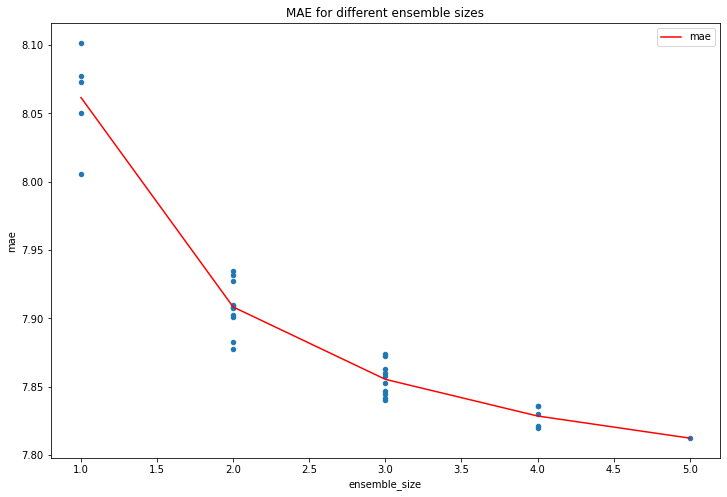

In [368]:
#we create ensemble predictions for every combination of sub-models of size k

ensemble_candidates = pd.DataFrame()
for k in range(1,6):
    combinations = []
    find_combinations([], prediction_cols, k)
    for combi in combinations: 
        mae = mean_absolute_error(test_dataframe[combi].mean(axis=1), test_dataframe.new_ys)
        ensemble_candidates = ensemble_candidates.append({'ensemble_size':k, 'mae':mae, 'combination': combi},
                                                      ignore_index=True)      
fig, ax = plt.subplots(figsize=(12,8))
ensemble_candidates.plot(x='ensemble_size', y='mae', ax=ax, kind='scatter');
ensemble_candidates.groupby('ensemble_size').mean().plot(ax=ax, label='mean', c='r');
ax.set_title('MAE for different ensemble sizes');

print(f'{"TOP 5":=^100}')
display(ensemble_candidates.sort_values('mae').head(5))  
print()

print(f'{"BOTTOM 5":=^100}')
display(ensemble_candidates.sort_values('mae').tail(5))  

In [404]:
ensemble_candidates

,ensemble_size,mae,combination
0,1.000,8.102,[baseline_prediction]
1,1.000,8.073,[bottleneck_prediction]
2,1.000,8.077,[baseline_prediction_moodys]
3,1.000,8.050,[bottleneck_prediction_moodys]
4,1.000,8.006,[pretrained_prediction_moodys]
5,2.000,7.927,"[baseline_prediction, bottleneck_prediction]"
6,2.000,7.932,"[baseline_prediction, baseline_prediction_moodys]"
7,2.000,7.910,"[baseline_prediction, bottleneck_prediction_mo..."
8,2.000,7.883,"[baseline_prediction, pretrained_prediction_mo..."
9,2.000,7.901,"[bottleneck_prediction, baseline_prediction_mo..."


#### Hypothesis 1: 
Better performance from ensemble model comes most from the extreme predictions where the model predictions are all over the place, so averaging the helps. This is less pronounced for the easy predictions.

Test 1: 

Is there correlation between the MAE on a 2-model ensemble and the pairwise correlation in their predictions on outlier trades (those with large last_ys)? 

It is possible that models with higher correlation in prediction errors are more likely to be similar, and so they benefit less from ensembling and hence have a higher MAE.

The results below show a weak relationship here.

In [405]:
corr_candidates = ensemble_candidates[ensemble_candidates.ensemble_size==2]\
                                    .set_index('combination')\
                                    .sort_values('mae')\

In [363]:
col = 'last_yield'
lower = 150 #test_dataframe[col].quantile(.1)
upper = 700 #test_dataframe[col].quantile(.9)
upper_lower_filter = (test_dataframe[col]<lower) | (test_dataframe[col]>upper)

corr_df = test_dataframe[upper_lower_filter][error_cols].corr()
corr_summary = pd.DataFrame()

for x,y in corr_candidates.index: 
    corr_summary = corr_summary.append({'Combination':(x,y), 'Corr':corr_df.loc[x+'_error',y+'_error']},
                                      ignore_index=True)
corr_summary['mae'] = corr_candidates['mae'].values
display(corr_summary)
print(corr_summary.corr())

,Combination,Corr,mae
0,"(baseline_prediction_moodys, pretrained_predic...",0.632,7.878
1,"(baseline_prediction, pretrained_prediction_mo...",0.840,7.883
2,"(bottleneck_prediction, baseline_prediction_mo...",0.779,7.901
3,"(baseline_prediction_moodys, bottleneck_predic...",0.345,7.903
4,"(bottleneck_prediction_moodys, pretrained_pred...",0.804,7.908
5,"(bottleneck_prediction, pretrained_prediction_...",0.756,7.908
6,"(baseline_prediction, bottleneck_prediction_mo...",0.769,7.910
7,"(baseline_prediction, bottleneck_prediction)",0.889,7.927
8,"(baseline_prediction, baseline_prediction_moodys)",0.781,7.932
9,"(bottleneck_prediction, bottleneck_prediction_...",0.634,7.935


      Corr   mae
Corr 1.000 0.137
mae  0.137 1.000


**Verdict: no obvious trend for this hypothesis, but perhaps we can dig deeper**

Test 2: the improvement in MAE from ensembling is just most pronounced in outlier trades

We look at the hypothesis directly. Maybe MAE just improves more for outlier trades. We do this by looking at MAE improvements between all trades and trades that fall beyond the 1/5/10 percentile extremes based on last_yield.

In [47]:
def compare_mae_ranges(df, error_cols=error_cols):
    mae_range = []
    for col in error_cols:
        mae = abs(df[col]).mean()
        mae_range.append(mae)
        print(f'{col:50}: {mae:.2f}')
    
    mae = mean_absolute_error(df[prediction_cols].mean(axis=1), df.new_ys)
    print(f'{"COMBINED AVG PREDICTION":50}: {mae:.2f}\n')
    print(f'{"MAE RANGE (INDIVIDUAL MODELS):":50}: {max(mae_range) - min(mae_range):.2f}')
    print(f'{"MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):":50}: {min(mae_range) - mae:.2f}\n')

In [377]:
col = 'last_yield'
lower = test_dataframe[col].quantile(.001)
upper = test_dataframe[col].quantile(.999)
upper_lower_filter = (test_dataframe[col]<lower) | (test_dataframe[col]>upper)

print(f'{f"ALL TRADES (N = {len(test_dataframe)})":=^75}')
compare_mae_ranges(test_dataframe)
print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe)-upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[~upper_lower_filter])
print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[upper_lower_filter])

==========================ALL TRADES (N = 720563)==========================
baseline_prediction_error                         : 8.10
bottleneck_prediction_error                       : 8.07
baseline_prediction_moodys_error                  : 8.08
bottleneck_prediction_moodys_error                : 8.05
pretrained_prediction_moodys_error                : 8.01
COMBINED AVG PREDICTION                           : 7.81

MAE RANGE (INDIVIDUAL MODELS):                    : 0.10
MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.19

===============1.00% < last_yield < 7.00% TRADES (N=719186)================
baseline_prediction_error                         : 8.04
bottleneck_prediction_error                       : 8.02
baseline_prediction_moodys_error                  : 8.01
bottleneck_prediction_moodys_error                : 8.00
pretrained_prediction_moodys_error                : 7.95
COMBINED AVG PREDICTION                           : 7.76

MAE RANGE (INDIVIDUAL MODELS):                 

In [378]:
col = 'last_yield'
lower = test_dataframe[col].quantile(.01)
upper = test_dataframe[col].quantile(.99)
upper_lower_filter = (test_dataframe[col]<lower) | (test_dataframe[col]>upper)

print(f'{f"ALL TRADES (N = {len(test_dataframe)})":=^75}')
compare_mae_ranges(test_dataframe)
print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe)-upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[~upper_lower_filter])
print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[upper_lower_filter])

==========================ALL TRADES (N = 720563)==========================
baseline_prediction_error                         : 8.10
bottleneck_prediction_error                       : 8.07
baseline_prediction_moodys_error                  : 8.08
bottleneck_prediction_moodys_error                : 8.05
pretrained_prediction_moodys_error                : 8.01
COMBINED AVG PREDICTION                           : 7.81

MAE RANGE (INDIVIDUAL MODELS):                    : 0.10
MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.19

===============2.30% < last_yield < 5.62% TRADES (N=706375)================
baseline_prediction_error                         : 7.94
bottleneck_prediction_error                       : 7.91
baseline_prediction_moodys_error                  : 7.91
bottleneck_prediction_moodys_error                : 7.89
pretrained_prediction_moodys_error                : 7.84
COMBINED AVG PREDICTION                           : 7.66

MAE RANGE (INDIVIDUAL MODELS):                 

In [379]:
col = 'last_yield'
lower = test_dataframe[col].quantile(.05)
upper = test_dataframe[col].quantile(.95)
upper_lower_filter = (test_dataframe[col]<lower) | (test_dataframe[col]>upper)

print(f'{f"ALL TRADES (N = {len(test_dataframe)})":=^75}')
compare_mae_ranges(test_dataframe)
print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe)-upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[~upper_lower_filter])
print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[upper_lower_filter])

==========================ALL TRADES (N = 720563)==========================
baseline_prediction_error                         : 8.10
bottleneck_prediction_error                       : 8.07
baseline_prediction_moodys_error                  : 8.08
bottleneck_prediction_moodys_error                : 8.05
pretrained_prediction_moodys_error                : 8.01
COMBINED AVG PREDICTION                           : 7.81

MAE RANGE (INDIVIDUAL MODELS):                    : 0.10
MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.19

===============2.64% < last_yield < 4.99% TRADES (N=648820)================
baseline_prediction_error                         : 7.82
bottleneck_prediction_error                       : 7.81
baseline_prediction_moodys_error                  : 7.82
bottleneck_prediction_moodys_error                : 7.80
pretrained_prediction_moodys_error                : 7.75
COMBINED AVG PREDICTION                           : 7.57

MAE RANGE (INDIVIDUAL MODELS):                 

Indeed, trades with extreme values of last_yield benefit 2-3 times more than regular trades. A worthwhile question here is how much matters in pratice - in production we already either 1. refuse prediction on trades with extremely high values of last yield or 2. use the dollar price model for trades with negative yields or null yields in trade history. Nonetheless, the ensemble still shows there is about .2bps to be gained from ensembling

#### Testing Gil's production idea: 

Ensembling improves performance but it might be unruly to send k inputs to k different models. Gil's suggestion is as follows: rather than having k models on vertex AI, just combine all 5 into a single model using the keras Average layer so that we can have a single model with a single endpoint on vertex AI and a single GPU can be maximized.

In [69]:
inputs = []
outputs = [] 
i = 0
for model in [baseline_model, new_model, baseline_model_moodys, new_model_moodys, new_model_moodys_pretrained]:
    
    #layer names will clash, we just rename it to a random number for now
    for layer in model.layers:
        layer._name = str(i)
        i+= 1
    
    inputs.append(model.input)
    outputs.append(model.output)

combined_output = layers.Average()(outputs)
BIG_MODEL = keras.Model(inputs=inputs, outputs=combined_output)
BIG_MODEL.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

In [70]:
modify_features(['moodys_rating', 'ratings_concat'], how = 'remove')   
modify_features(['rating'], how = 'add', where='categorical') 
x_train = create_input(train_dataframe, moodys = False)
modify_features(['rating', 'moodys_rating'], how = 'add', where='categorical') 
x_train_moodys = create_input(train_dataframe, moodys = True)
trade_history_x_train_moodys, reference_x_train_moodys = create_input_pretrained(train_dataframe, moodys = True)

In [71]:
y_train = train_dataframe[target_variable]

In [75]:
%%time
COMBINED_PREDICTIONS  = BIG_MODEL.predict([x_test, x_test, x_test_moodys, x_test_moodys, [trade_history_x_test_moodys, reference_x_test_moodys]], batch_size=5120)
mean_absolute_error(test_dataframe.new_ys, COMBINED_PREDICTIONS)

CPU times: user 11.4 s, sys: 3.32 s, total: 14.7 s
Wall time: 12.2 s


7.812385972376441

In [76]:
%%time 
testtest  = new_model.predict(x_test, batch_size=5120)

CPU times: user 2.82 s, sys: 879 ms, total: 3.7 s
Wall time: 2.79 s


In [36]:
tf.keras.backend.clear_session()
gc.collect()

50268

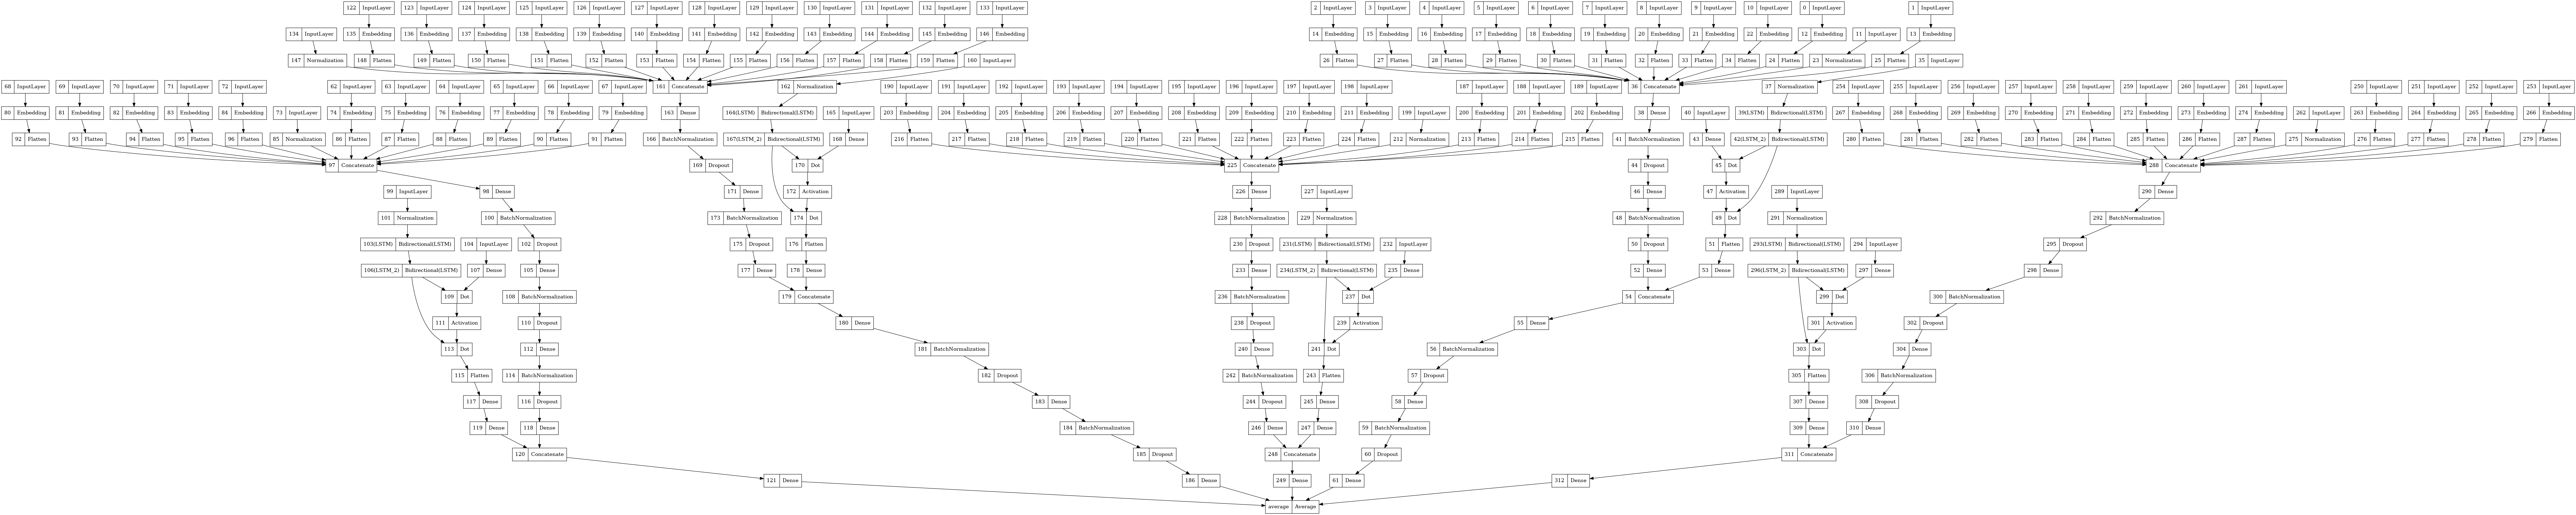

In [55]:
keras.utils.plot_model(BIG_MODEL)

**Conclusion: this is a good idea and the model latency does not change when we combine them into a single model**

## Testing the Ensemble where all models have the same architecture 

In production, training the same model several times is simpler and less error prone than training multiple models, but it is not clear if this has the same diversification benefits as using models with slightly different features or architectures. Broadly speaking, unless there is sufficient divergence in how the models converge to different local optima, there will be an extremely high degree of correlation between the models - averaging them in an ensemble will then yield little to no benefit. 

One idea is to increase dropout to hopefully force models to use slightly different feature sets from one another. During training, with p(dropout) = x%, there is an x% chance that a neuron is excluded from the forward and backward propogation phase of training. This reduces the feature set available to the model in each batch, on average, by x\*N, where N is the number of nodes in the model. 

Ideally, this reduces model dependence on any single feature and encourages better generalizability. **From an ensemble perspective, it is reasonable to believe that this causes the models to converge to different optima. Interestingly, this is shown to not be the case below. In testing dropout of 0.1 and 0.25, we find that the ensemble with higher dropout has submodels that are MORE correlated with one another than the ensemble with lower dropout.**

One intuition here is that, with higher dropout and more generaliazility, the models actually converge to very similar optima. On the other hand, with less dropout the random initializations matter more and carry the models to different optima. This is difficult to test, but a look at correlations in errors reveals this is indeed the case. **Correlations in errors mean more than correlations in prediction which are almost always higher. I think this is because correlation in predictions between two sufficiently similar models captures both correlation between their deterministic and error components while correlation in error only captures correlation in errors. The former correlation is inflated by correlation in deterministic components.**

### Dropout 0.1

In [374]:
#this just adds and removes the ratings features from CATEGORICAL_FEATURES 
#NOTE: order of features in CATEGORICAL_FEATURES has to align with the models inputs at training, otherwise we will get funky predictions 
modify_features(['moodys_rating', 'ratings_concat','rating'], how = 'remove')   
modify_features(['rating'], how = 'add', where='categorical') 
x_test = create_input(test_dataframe, moodys = False)

In [375]:
ensemble_models = []
ensemble_pred = []
prefix = 'baseline_ensemble_'
ensemble_size = 11
for i in range(0, ensemble_size):
    model_path = prefix+str(i)
    curr_model = keras.models.load_model(model_path)
    
    curr_pred = curr_model.predict(x_test, batch_size=5000)
    print(f'{f"Trial {i}":30}: {mean_absolute_error(test_dataframe.new_ys, curr_pred):.3f}')
    
    ensemble_pred.append(curr_pred)
    ensemble_models.append(curr_model)
    

2023-08-15 21:08:29.368445: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 0                       : 8.094


2023-08-15 21:08:43.084139: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 1                       : 8.056


2023-08-15 21:08:56.136969: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 2                       : 8.030


2023-08-15 21:09:16.782016: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 3                       : 8.074


2023-08-15 21:09:29.841939: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 4                       : 8.075


2023-08-15 21:09:42.877574: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 5                       : 8.080


2023-08-15 21:09:55.918520: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 6                       : 8.054


2023-08-15 21:10:16.729849: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 7                       : 8.053


2023-08-15 21:10:55.356924: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 8                       : 8.076


2023-08-15 21:11:16.621129: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 9                       : 8.146


2023-08-15 21:11:29.327997: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 10                      : 8.101


In [376]:
ensemble_pred_df = pd.DataFrame(np.concatenate(ensemble_pred, axis=-1))
ensemble_cols = ['ensemble_'+str(i)+'_pred' for i in range(ensemble_size)]
test_dataframe[ensemble_cols] = ensemble_pred_df
del ensemble_pred_df 

In [377]:
ensemble_error_cols = []
for i in ensemble_cols:
    test_dataframe[i[:-5]+'_error'] = test_dataframe.new_ys - test_dataframe[i]
    ensemble_error_cols.append(i[:-5]+'_error')

,ensemble_size,mae,combination
1815,8.000,7.886,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1980,9.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1520,7.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1850,8.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1935,8.000,7.887,"[ensemble_1_pred, ensemble_2_pred, ensemble_3_..."
...,...,...,...
8,1.000,8.076,[ensemble_8_pred]
5,1.000,8.080,[ensemble_5_pred]
0,1.000,8.094,[ensemble_0_pred]
10,1.000,8.101,[ensemble_10_pred]


===============================================TOP 5================================================


,ensemble_size,mae,combination
1815,8.000,7.886,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1980,9.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1520,7.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1850,8.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1935,8.000,7.887,"[ensemble_1_pred, ensemble_2_pred, ensemble_3_..."



==============================================BOTTOM 5==============================================


,ensemble_size,mae,combination
8,1.000,8.076,[ensemble_8_pred]
5,1.000,8.080,[ensemble_5_pred]
0,1.000,8.094,[ensemble_0_pred]
10,1.000,8.101,[ensemble_10_pred]
9,1.000,8.146,[ensemble_9_pred]


CPU times: user 44.9 s, sys: 0 ns, total: 44.9 s
Wall time: 44.9 s


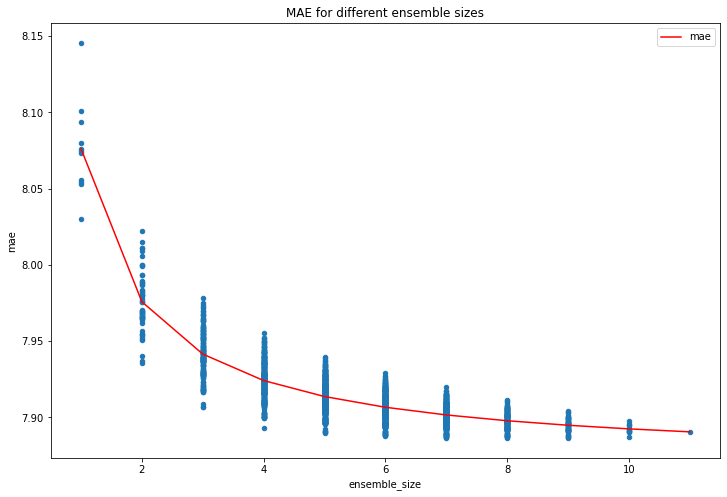

In [378]:
%%time

ensemble_candidates = pd.DataFrame()
for k in range(1,ensemble_size+1):
    combinations = []
    find_combinations([], ensemble_cols, k)
    for combi in combinations: 
        mae = mean_absolute_error(test_dataframe[combi].mean(axis=1), test_dataframe.new_ys)
        ensemble_candidates = ensemble_candidates.append({'ensemble_size':k, 'mae':mae, 'combination': combi},
                                                      ignore_index=True)      
fig, ax = plt.subplots(figsize=(12,8))
ensemble_candidates.plot(x='ensemble_size', y='mae', ax=ax, kind='scatter');
ensemble_candidates.groupby('ensemble_size').mean().plot(ax=ax, label='mean', c='r');
ax.set_title('MAE for different ensemble sizes');

display(ensemble_candidates.sort_values('mae'))  

print(f'{"TOP 5":=^100}')
display(ensemble_candidates.sort_values('mae').head(5))  
print()

print(f'{"BOTTOM 5":=^100}')
display(ensemble_candidates.sort_values('mae').tail(5))  

The graph above shows quite conclusively that the benefits of ensembling are subject to diminishing returns, and past around 6 models there is little to be gained. The benefit of ensembling is two-fold in our case: 
1. Improved MAE 
2. Reduced variance in model performance

The latter is reflected in how the range of possible MAE values tightens the larger the ensemble size. Tables below summarize the average and best performance for each ensemble size

In [344]:
ensemble_candidates.groupby('ensemble_size')

In [345]:
dropout_01_summary = ensemble_candidates.groupby('ensemble_size').agg(['mean','std']).fillna(0)

In [326]:
#average and best performance by ensemble size 
ensemble_candidates.groupby('ensemble_size').mae.agg(['mean','min'])

,mean,min
ensemble_size,,
1.000,8.066,8.030
2.000,7.966,7.937
3.000,7.932,7.918
4.000,7.915,7.909
5.000,7.904,7.904


In [59]:
ensemble_candidates.sort_values('mae').head(25)

,ensemble_size,mae,combination
1815,8.000,7.886,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1980,9.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1520,7.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1850,8.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1935,8.000,7.887,"[ensemble_1_pred, ensemble_2_pred, ensemble_3_..."
1982,9.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
2036,10.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1695,7.000,7.887,"[ensemble_1_pred, ensemble_2_pred, ensemble_3_..."
1500,7.000,7.887,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
1730,7.000,7.887,"[ensemble_1_pred, ensemble_2_pred, ensemble_4_..."


In [127]:
def compare_mae_ranges(df, prediction_cols = ensemble_cols, error_cols=ensemble_error_cols):
    mae_range = []
    mad_range = []
    for col in error_cols:
        mae = abs(df[col]).mean()
        mad = abs(df[col]).median()
        mae_range.append(mae)
        mad_range.append(mad)
        print(f'{col:50}: MAE: {mae:.2f};    MAD: {mad:.2f}')
    
    mae = mean_absolute_error(df[prediction_cols].mean(axis=1), df.new_ys)
    mad = abs(df[prediction_cols].mean(axis=1) - df.new_ys).median() 
    print(f'{"COMBINED AVG PREDICTION":50}: MAE: {mae:.2f};    MAD: {mad:.2f}\n')
    print(f'{"MAE RANGE (INDIVIDUAL MODELS):":50}: {max(mae_range) - min(mae_range):.2f}')
    print(f'{"MAD RANGE (INDIVIDUAL MODELS):":50}: {max(mad_range) - min(mad_range):.2f}\n')
    print(f'{"MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):":50}: {min(mae_range) - mae:.2f}')
    print(f'{"MAD IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):":50}: {min(mad_range) - mad:.2f}\n')
    
    print(f'{"MAE IMPROVEMENT (ENSEMBLE vs AVG):":50}: {sum(mae_range)/len(mae_range) - mae:.2f}')
    print(f'{"MAD IMPROVEMENT (ENSEMBLE vs AVG):":50}: {sum(mad_range)/len(mad_range) - mad:.2f}\n')
    
    print(f'{"NaN rows:":50}: {df[prediction_cols].isna().any(axis=1).sum():d}')

We summarize ensemble performance on all trades, then those within and beyond 2SD of last_yield. The MAE gain is roughly .1-.2 on regular trades and .2-.3 for outliers.

In [128]:
col = 'last_yield'
lower = test_dataframe[col].quantile(.05)
upper = test_dataframe[col].quantile(.95)
upper_lower_filter = (test_dataframe[col]<lower) | (test_dataframe[col]>upper)

print(f'{f"ALL TRADES (N = {len(test_dataframe)})":=^75}')
compare_mae_ranges(test_dataframe, ensemble_cols, ensemble_error_cols)
print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe)-upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[~upper_lower_filter], ensemble_cols, ensemble_error_cols)
print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[upper_lower_filter], ensemble_cols, ensemble_error_cols)

==========================ALL TRADES (N = 720563)==========================
ensemble_0_error                                  : MAE: 8.09;    MAD: 4.73
ensemble_1_error                                  : MAE: 8.06;    MAD: 4.74
ensemble_2_error                                  : MAE: 8.03;    MAD: 4.73
ensemble_3_error                                  : MAE: 8.07;    MAD: 4.75
ensemble_4_error                                  : MAE: 8.07;    MAD: 4.76
ensemble_5_error                                  : MAE: 8.08;    MAD: 4.73
ensemble_6_error                                  : MAE: 8.05;    MAD: 4.72
ensemble_7_error                                  : MAE: 8.05;    MAD: 4.71
ensemble_8_error                                  : MAE: 8.08;    MAD: 4.74
ensemble_9_error                                  : MAE: 8.15;    MAD: 4.79
ensemble_10_error                                 : MAE: 8.10;    MAD: 4.78
COMBINED AVG PREDICTION                           : MAE: 7.89;    MAD: 4.62

MAE RANGE (

In [164]:
test_dataframe[ensemble_error_cols].corr()

,ensemble_0_error,ensemble_1_error,ensemble_2_error,ensemble_3_error,ensemble_4_error,ensemble_5_error,ensemble_6_error,ensemble_7_error,ensemble_8_error,ensemble_9_error,ensemble_10_error
ensemble_0_error,1.000,0.934,0.924,0.949,0.945,0.922,0.874,0.929,0.945,0.927,0.944
ensemble_1_error,0.934,1.000,0.948,0.954,0.954,0.949,0.916,0.955,0.958,0.949,0.949
ensemble_2_error,0.924,0.948,1.000,0.950,0.942,0.951,0.943,0.956,0.951,0.940,0.928
ensemble_3_error,0.949,0.954,0.950,1.000,0.958,0.948,0.910,0.955,0.961,0.947,0.950
ensemble_4_error,0.945,0.954,0.942,0.958,1.000,0.943,0.900,0.950,0.959,0.940,0.957
ensemble_5_error,0.922,0.949,0.951,0.948,0.943,1.000,0.925,0.955,0.950,0.927,0.939
ensemble_6_error,0.874,0.916,0.943,0.910,0.900,0.925,1.000,0.933,0.912,0.913,0.876
ensemble_7_error,0.929,0.955,0.956,0.955,0.950,0.955,0.933,1.000,0.956,0.941,0.940
ensemble_8_error,0.945,0.958,0.951,0.961,0.959,0.950,0.912,0.956,1.000,0.947,0.955
ensemble_9_error,0.927,0.949,0.940,0.947,0.940,0.927,0.913,0.941,0.947,1.000,0.928


In [129]:
test_dataframe[ensemble_cols].corr()

,ensemble_0_pred,ensemble_1_pred,ensemble_2_pred,ensemble_3_pred,ensemble_4_pred,ensemble_5_pred,ensemble_6_pred,ensemble_7_pred,ensemble_8_pred,ensemble_9_pred,ensemble_10_pred
ensemble_0_pred,1.000,0.997,0.996,0.997,0.997,0.996,0.993,0.996,0.997,0.996,0.997
ensemble_1_pred,0.997,1.000,0.998,0.998,0.998,0.998,0.996,0.998,0.998,0.997,0.997
ensemble_2_pred,0.996,0.998,1.000,0.998,0.997,0.998,0.997,0.998,0.998,0.997,0.996
ensemble_3_pred,0.997,0.998,0.998,1.000,0.998,0.997,0.995,0.998,0.998,0.997,0.997
ensemble_4_pred,0.997,0.998,0.997,0.998,1.000,0.997,0.995,0.998,0.998,0.997,0.998
ensemble_5_pred,0.996,0.998,0.998,0.997,0.997,1.000,0.996,0.998,0.998,0.996,0.997
ensemble_6_pred,0.993,0.996,0.997,0.995,0.995,0.996,1.000,0.997,0.996,0.996,0.994
ensemble_7_pred,0.996,0.998,0.998,0.998,0.998,0.998,0.997,1.000,0.998,0.997,0.997
ensemble_8_pred,0.997,0.998,0.998,0.998,0.998,0.998,0.996,0.998,1.000,0.997,0.998
ensemble_9_pred,0.996,0.997,0.997,0.997,0.997,0.996,0.996,0.997,0.997,1.000,0.996


Here we look at the correlations between errors in the ensemble, both means and minimums.

In [163]:
for col in ensemble_error_cols:
    print(f'{col}: {test_dataframe[ensemble_error_cols].corr()[col].drop(col).mean():.3f}')

ensemble_0_error: 0.929
ensemble_1_error: 0.947
ensemble_2_error: 0.943
ensemble_3_error: 0.948
ensemble_4_error: 0.945
ensemble_5_error: 0.941
ensemble_6_error: 0.910
ensemble_7_error: 0.947
ensemble_8_error: 0.949
ensemble_9_error: 0.936
ensemble_10_error: 0.937


In [131]:
test_dataframe[ensemble_error_cols].corr().min()

ensemble_0_error    0.874
ensemble_1_error    0.916
ensemble_2_error    0.924
ensemble_3_error    0.910
ensemble_4_error    0.900
ensemble_5_error    0.922
ensemble_6_error    0.874
ensemble_7_error    0.929
ensemble_8_error    0.912
ensemble_9_error    0.913
ensemble_10_error   0.876
dtype: float64

Looking at model agreement/disagreement:

In [380]:
disagreement = test_dataframe[ensemble_cols].parallel_apply(lambda x: abs(x.max() - x.min()), axis=1)
volatility = test_dataframe[ensemble_cols].parallel_apply(lambda x: x.std(), axis=1)
test_dataframe['ensemble_disagreement'] = disagreement 
test_dataframe['ensemble_volatility'] = volatility 

In [386]:
last_yield_95_5 = (test_dataframe.last_yield >= test_dataframe.last_yield.quantile(.5)) & (test_dataframe.last_yield <= test_dataframe.last_yield.quantile(.95))
_, _ = top_bottom_K(test_dataframe[last_yield_95_5], 100, 100, 'ensemble_disagreement', ensemble_cols)

=====================SUMMARY:=====================
MEAN:     6.66; MEDIAN:   4.88; STD:      6.13

===================PERCENTILES:===================
5%:       4.88; 33%:      3.46; 67%:      6.93; 95%:      17.51
MAX:     203.63; MIN:     0.50

TOP 10 TRADES WITH BIGGEST ENSEMBLE_DISAGREEMENT


,rtrs_control_number,cusip,trade_datetime,new_ys,ensemble_0_pred,ensemble_1_pred,ensemble_2_pred,ensemble_3_pred,ensemble_4_pred,ensemble_5_pred,ensemble_6_pred,ensemble_7_pred,ensemble_8_pred,ensemble_9_pred,ensemble_10_pred
32517,2023060106710600,08451PAE1,2023-06-01 12:38:11,2967.602,490.482,1770.116,2219.382,1434.866,1368.951,1971.962,3023.538,2084.791,1598.852,1886.978,1071.615
22724,2023060103442300,08451PAE1,2023-06-01 10:57:33,2990.911,339.917,1661.654,2132.402,1412.949,1299.125,1823.669,2793.332,1976.064,1543.169,1839.593,1004.724
653555,2023062804362100,08451PAD3,2023-06-28 12:03:35,1485.566,666.172,1707.235,2097.490,1466.554,1344.625,1917.176,2893.962,1974.181,1532.856,1826.426,1114.171
653553,2023062804369300,08451PAD3,2023-06-28 12:03:35,1495.366,750.434,1724.239,2132.077,1513.073,1353.292,1936.458,2917.172,2018.069,1551.194,1855.848,1072.672
32619,2023060106705300,08451PAF8,2023-06-01 12:39:15,2184.013,1415.942,1602.498,1913.483,1067.378,1418.018,1812.334,2358.049,1410.705,1467.934,1407.613,1389.155
665796,2023062911219600,13080SEW0,2023-06-29 16:10:17,217.683,423.047,358.430,157.986,275.720,191.178,-237.169,162.073,265.827,237.689,907.754,46.131
475433,2023062100948600,08451PAF8,2023-06-21 09:40:21,1080.653,1805.550,1569.001,1768.350,1529.356,1266.100,1716.144,2302.786,1678.623,1328.097,1689.404,1191.252
475434,2023062100936900,08451PAF8,2023-06-21 09:40:21,1078.953,1805.550,1569.001,1768.350,1529.356,1266.100,1716.144,2302.786,1678.623,1328.097,1689.404,1191.252
475432,2023062100943200,08451PAF8,2023-06-21 09:40:21,1091.953,1805.550,1569.001,1768.350,1529.356,1266.100,1716.144,2302.786,1678.623,1328.097,1689.404,1191.252
475431,2023062100936300,08451PAF8,2023-06-21 09:40:21,1010.753,1687.470,1510.989,1729.378,1448.769,1250.222,1686.444,2263.974,1622.539,1318.294,1670.668,1207.464


TOP 10 TRADES WITH SMALLEST ENSEMBLE_DISAGREEMENT


,rtrs_control_number,cusip,trade_datetime,new_ys,ensemble_0_pred,ensemble_1_pred,ensemble_2_pred,ensemble_3_pred,ensemble_4_pred,ensemble_5_pred,ensemble_6_pred,ensemble_7_pred,ensemble_8_pred,ensemble_9_pred,ensemble_10_pred
706905,2023063001962500,13068LN68,2023-06-30 10:32:04,4.803,6.485,6.343,6.227,6.544,6.507,6.164,6.554,6.262,6.608,6.505,6.674
216174,2023060803948000,4470254Q7,2023-06-08 11:37:46,66.588,66.607,66.723,66.885,66.546,66.590,66.503,66.767,66.579,66.380,66.634,66.735
589174,2023062707990900,647719PV9,2023-06-27 14:24:35,17.437,16.797,16.924,17.048,16.985,17.007,16.560,16.986,16.586,16.550,16.757,16.763
589177,2023062707991100,647719PV9,2023-06-27 14:24:37,17.437,16.675,16.959,16.882,16.859,16.871,16.648,16.908,16.462,16.749,16.742,16.813
581176,2023062603070600,983366EF8,2023-06-26 11:38:35,38.977,17.960,17.865,18.102,17.989,17.871,17.902,18.232,17.862,18.302,17.850,17.827
459360,2023062110578000,465650Q93,2023-06-21 15:50:27,5.886,3.485,3.428,3.181,3.539,3.245,3.360,3.645,3.492,3.456,3.564,3.480
459351,2023062110582700,465650Q93,2023-06-21 15:50:27,3.386,3.485,3.428,3.181,3.539,3.245,3.360,3.645,3.492,3.456,3.564,3.480
459034,2023062110316900,362848UJ0,2023-06-21 15:41:13,28.653,29.080,28.621,28.700,29.049,29.011,28.859,28.675,28.692,29.049,28.926,29.080
87881,2023060508488200,592112RD0,2023-06-05 14:43:37,15.699,15.385,15.565,15.427,15.607,15.694,15.288,15.668,15.322,15.340,15.333,15.590
276827,2023061307638900,522426QP3,2023-06-13 14:03:14,13.924,16.935,16.907,16.773,16.838,16.758,16.800,17.023,16.680,16.713,17.083,17.029


### Dropout 0.25

In [391]:
#this just adds and removes the ratings features from CATEGORICAL_FEATURES 
#NOTE: order of features in CATEGORICAL_FEATURES has to align with the models inputs at training, otherwise we will get funky predictions 
modify_features(['moodys_rating', 'ratings_concat','rating'], how = 'remove')   
modify_features(['rating'], how = 'add', where='categorical') 
x_test = create_input(test_dataframe, moodys = False)

In [392]:
ensemble_models = []
ensemble_pred = []
prefix = 'baseline_ensemble_dropout0.25_'
ensemble_size = 5
for i in range(1, ensemble_size+1):
    model_path = prefix+str(i)
    curr_model = keras.models.load_model(model_path)
    
    curr_pred = curr_model.predict(x_test, batch_size=5000)
    print(f'{f"Trial {i}":30}: {mean_absolute_error(test_dataframe.new_ys, curr_pred):.3f}')
    
    ensemble_pred.append(curr_pred)
    ensemble_models.append(curr_model)
    

2023-08-15 21:19:15.627001: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 1                       : 8.098


2023-08-15 21:19:28.762797: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 2                       : 8.074


2023-08-15 21:19:41.939283: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 3                       : 8.070


2023-08-15 21:20:29.729249: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 4                       : 8.145


2023-08-15 21:20:43.371019: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Trial 5                       : 8.027


In [393]:
ensemble_pred_df = pd.DataFrame(np.concatenate(ensemble_pred, axis=-1))
ensemble_cols = ['ensemble_'+str(i)+'_pred' for i in range(ensemble_size)]
test_dataframe[ensemble_cols] = ensemble_pred_df
del ensemble_pred_df 

ensemble_error_cols = []
for i in ensemble_cols:
    test_dataframe[i[:-5]+'_error'] = test_dataframe.new_ys - test_dataframe[i]
    ensemble_error_cols.append(i[:-5]+'_error')

,ensemble_size,mae,combination
22,3.000,7.981,"[ensemble_1_pred, ensemble_2_pred, ensemble_4_..."
26,4.000,7.981,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
17,3.000,7.986,"[ensemble_0_pred, ensemble_1_pred, ensemble_4_..."
19,3.000,7.987,"[ensemble_0_pred, ensemble_2_pred, ensemble_4_..."
11,2.000,7.987,"[ensemble_1_pred, ensemble_4_pred]"
30,5.000,7.991,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
29,4.000,7.993,"[ensemble_1_pred, ensemble_2_pred, ensemble_3_..."
13,2.000,7.995,"[ensemble_2_pred, ensemble_4_pred]"
8,2.000,7.996,"[ensemble_0_pred, ensemble_4_pred]"
27,4.000,7.997,"[ensemble_0_pred, ensemble_1_pred, ensemble_3_..."


===============================================TOP 5================================================


,ensemble_size,mae,combination
22,3.000,7.981,"[ensemble_1_pred, ensemble_2_pred, ensemble_4_..."
26,4.000,7.981,"[ensemble_0_pred, ensemble_1_pred, ensemble_2_..."
17,3.000,7.986,"[ensemble_0_pred, ensemble_1_pred, ensemble_4_..."
19,3.000,7.987,"[ensemble_0_pred, ensemble_2_pred, ensemble_4_..."
11,2.000,7.987,"[ensemble_1_pred, ensemble_4_pred]"



==============================================BOTTOM 5==============================================


,ensemble_size,mae,combination
7,2.000,8.066,"[ensemble_0_pred, ensemble_3_pred]"
2,1.000,8.070,[ensemble_2_pred]
1,1.000,8.074,[ensemble_1_pred]
0,1.000,8.098,[ensemble_0_pred]
3,1.000,8.145,[ensemble_3_pred]


CPU times: user 489 ms, sys: 0 ns, total: 489 ms
Wall time: 486 ms


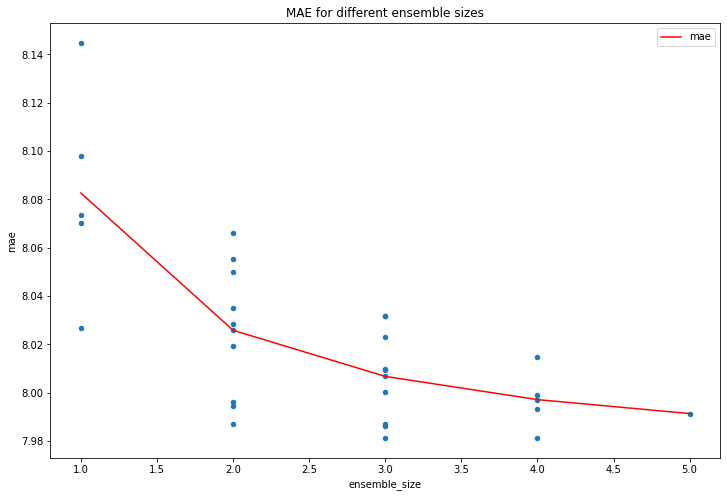

In [334]:
%%time

ensemble_candidates = pd.DataFrame()
for k in range(1,ensemble_size+1):
    combinations = []
    find_combinations([], ensemble_cols, k)
    for combi in combinations: 
        mae = mean_absolute_error(test_dataframe[combi].mean(axis=1), test_dataframe.new_ys)
        ensemble_candidates = ensemble_candidates.append({'ensemble_size':k, 'mae':mae, 'combination': combi},
                                                      ignore_index=True)      
fig, ax = plt.subplots(figsize=(12,8))
ensemble_candidates.plot(x='ensemble_size', y='mae', ax=ax, kind='scatter');
ensemble_candidates.groupby('ensemble_size').mean().plot(ax=ax, label='mean', c='r');
ax.set_title('MAE for different ensemble sizes');

display(ensemble_candidates.sort_values('mae'))  

print(f'{"TOP 5":=^100}')
display(ensemble_candidates.sort_values('mae').head(5))  
print()

print(f'{"BOTTOM 5":=^100}')
display(ensemble_candidates.sort_values('mae').tail(5))  

In [335]:
dropout_25_summary = ensemble_candidates.groupby('ensemble_size').agg(['mean','std']).fillna(0)

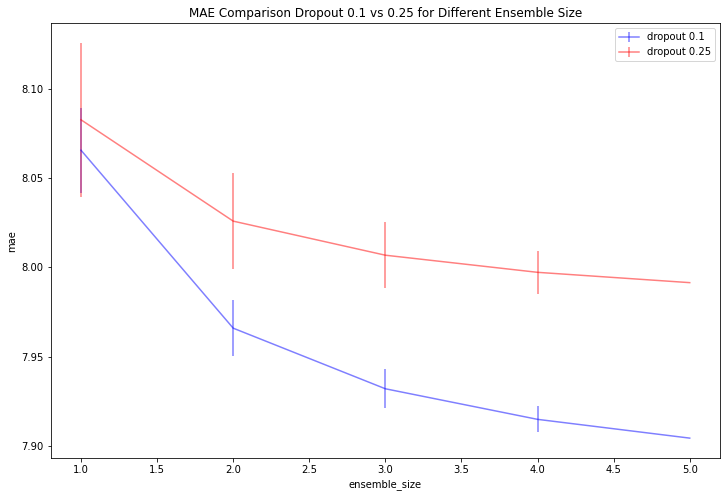

In [349]:
fig, ax = plt.subplots(figsize=(12,8))


ax.errorbar(x = range(1,6), y = dropout_01_summary.iloc[:5][('mae','mean')], yerr=dropout_01_summary.iloc[:5][('mae','std')], label='dropout 0.1', c='b', alpha = 0.5);
ax.errorbar(x = range(1,6), y = dropout_25_summary.iloc[:5][('mae','mean')], yerr=dropout_25_summary.iloc[:5][('mae','std')], c='r', label='dropout 0.25', alpha = 0.5);
ax.set_xlabel('ensemble_size');
ax.set_ylabel('mae');
ax.set_title('MAE Comparison Dropout 0.1 vs 0.25 for Different Ensemble Size')
ax.legend()

In [307]:
pd.merge(dropout_01_summary, dropout_25_summary, left_index=True, right_index=True)

mae_x       mae_y      
               mean   std  mean   std
ensemble_size                        
1.000         8.076 0.031 8.083 0.043
2.000         7.976 0.020 8.026 0.027
3.000         7.942 0.015 8.007 0.018
4.000         7.924 0.012 7.997 0.012
5.000         7.914 0.010 7.991 0.000

In [192]:
col = 'last_yield'
lower = test_dataframe[col].quantile(.05)
upper = test_dataframe[col].quantile(.95)
upper_lower_filter = (test_dataframe[col]<lower) | (test_dataframe[col]>upper)

print(f'{f"ALL TRADES (N = {len(test_dataframe)})":=^75}')
compare_mae_ranges(test_dataframe, ensemble_cols, ensemble_error_cols)
print(f'{f"{lower/100:.2f}% < last_yield < {upper/100:.2f}% TRADES (N={len(test_dataframe)-upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[~upper_lower_filter], ensemble_cols, ensemble_error_cols)
print(f'{f"last_yield < {lower/100:.2f}% & last_yield > {upper/100:.2f}% TRADES (N={upper_lower_filter.sum()})":=^75}')
compare_mae_ranges(test_dataframe[upper_lower_filter], ensemble_cols, ensemble_error_cols)

==========================ALL TRADES (N = 720563)==========================
ensemble_0_error                                  : MAE: 8.10;    MAD: 4.76
ensemble_1_error                                  : MAE: 8.07;    MAD: 4.74
ensemble_2_error                                  : MAE: 8.07;    MAD: 4.74
ensemble_3_error                                  : MAE: 8.14;    MAD: 4.79
ensemble_4_error                                  : MAE: 8.03;    MAD: 4.71
COMBINED AVG PREDICTION                           : MAE: 7.99;    MAD: 4.68

MAE RANGE (INDIVIDUAL MODELS):                    : 0.12
MAD RANGE (INDIVIDUAL MODELS):                    : 0.09

MAE IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.04
MAD IMPROVEMENT (ENSEMBLE vs BEST INDIVIDUAL):    : 0.03

MAE IMPROVEMENT (ENSEMBLE vs AVG):                : 0.09
MAD IMPROVEMENT (ENSEMBLE vs AVG):                : 0.07

NaN rows:                                         : 0
===============2.64% < last_yield < 4.99% TRADES (N=648820)=========

Below we have a look at ensemble errors: they are consistently higher than in the 0.1 dropout ensemble

In [193]:
for col in ensemble_error_cols:
    print(f'{col}: {test_dataframe[ensemble_error_cols].corr()[col].drop(col).mean():.3f}')

ensemble_0_error: 0.981
ensemble_1_error: 0.981
ensemble_2_error: 0.982
ensemble_3_error: 0.981
ensemble_4_error: 0.980


In [169]:
test_dataframe[ensemble_error_cols].corr()

,ensemble_0_error,ensemble_1_error,ensemble_2_error,ensemble_3_error,ensemble_4_error
ensemble_0_error,1.000,0.983,0.982,0.981,0.980
ensemble_1_error,0.983,1.000,0.983,0.981,0.979
ensemble_2_error,0.982,0.983,1.000,0.982,0.980
ensemble_3_error,0.981,0.981,0.982,1.000,0.981
ensemble_4_error,0.980,0.979,0.980,0.981,1.000


In [168]:
test_dataframe[ensemble_cols].corr()

,ensemble_0_pred,ensemble_1_pred,ensemble_2_pred,ensemble_3_pred,ensemble_4_pred
ensemble_0_pred,1.000,0.999,0.999,0.999,0.999
ensemble_1_pred,0.999,1.000,0.999,0.999,0.999
ensemble_2_pred,0.999,0.999,1.000,0.999,0.999
ensemble_3_pred,0.999,0.999,0.999,1.000,0.999
ensemble_4_pred,0.999,0.999,0.999,0.999,1.000


In [395]:
ensemble_cols

['ensemble_0_pred',
 'ensemble_1_pred',
 'ensemble_2_pred',
 'ensemble_3_pred',
 'ensemble_4_pred']

In [394]:
disagreement = test_dataframe[ensemble_cols].parallel_apply(lambda x: abs(x.max() - x.min()), axis=1)
volatility = test_dataframe[ensemble_cols].parallel_apply(lambda x: x.std(), axis=1)
test_dataframe['ensemble_disagreement'] = disagreement 
test_dataframe['ensemble_volatility'] = volatility 

In [396]:
last_yield_95_5 = (test_dataframe.last_yield >= test_dataframe.last_yield.quantile(.5)) & (test_dataframe.last_yield <= test_dataframe.last_yield.quantile(.95))
_, _ = top_bottom_K(test_dataframe[last_yield_95_5], 100, 100, 'ensemble_disagreement', ensemble_cols)

=====================SUMMARY:=====================
MEAN:     3.61; MEDIAN:   2.75; STD:      3.36

===================PERCENTILES:===================
5%:       2.75; 33%:      2.03; 67%:      3.73; 95%:      9.08
MAX:     164.61; MIN:     0.06

TOP 10 TRADES WITH BIGGEST ENSEMBLE_DISAGREEMENT


,rtrs_control_number,cusip,trade_datetime,new_ys,ensemble_0_pred,ensemble_1_pred,ensemble_2_pred,ensemble_3_pred,ensemble_4_pred
32517,2023060106710600,08451PAE1,2023-06-01 12:38:11,2967.602,72.874,65.426,64.085,60.972,62.274
22724,2023060103442300,08451PAE1,2023-06-01 10:57:33,2990.911,67.227,71.717,67.326,68.272,70.026
653555,2023062804362100,08451PAD3,2023-06-28 12:03:35,1485.566,-12.651,-13.679,-12.668,-13.263,-12.641
653553,2023062804369300,08451PAD3,2023-06-28 12:03:35,1495.366,123.699,124.463,123.638,122.962,123.331
32619,2023060106705300,08451PAF8,2023-06-01 12:39:15,2184.013,50.789,54.753,53.451,57.009,59.816
665796,2023062911219600,13080SEW0,2023-06-29 16:10:17,217.683,8.624,7.947,8.393,8.393,8.545
475433,2023062100948600,08451PAF8,2023-06-21 09:40:21,1080.653,63.813,63.936,62.705,64.941,62.217
475434,2023062100936900,08451PAF8,2023-06-21 09:40:21,1078.953,9.294,10.428,10.266,11.210,9.841
475432,2023062100943200,08451PAF8,2023-06-21 09:40:21,1091.953,124.001,126.693,122.976,125.427,123.641
475431,2023062100936300,08451PAF8,2023-06-21 09:40:21,1010.753,-0.024,0.119,-0.629,0.128,-1.105


TOP 10 TRADES WITH SMALLEST ENSEMBLE_DISAGREEMENT


,rtrs_control_number,cusip,trade_datetime,new_ys,ensemble_0_pred,ensemble_1_pred,ensemble_2_pred,ensemble_3_pred,ensemble_4_pred
706905,2023063001962500,13068LN68,2023-06-30 10:32:04,4.803,-10.213,-10.121,-10.357,-9.512,-10.632
216174,2023060803948000,4470254Q7,2023-06-08 11:37:46,66.588,5.020,4.230,4.967,4.559,4.320
589174,2023062707990900,647719PV9,2023-06-27 14:24:35,17.437,-24.547,-25.969,-26.384,-27.388,-26.840
589177,2023062707991100,647719PV9,2023-06-27 14:24:37,17.437,8.805,8.140,8.163,8.557,5.976
581176,2023062603070600,983366EF8,2023-06-26 11:38:35,38.977,-25.208,-24.271,-23.429,-24.910,-23.849
459360,2023062110578000,465650Q93,2023-06-21 15:50:27,5.886,25.634,25.107,26.043,25.405,24.439
459351,2023062110582700,465650Q93,2023-06-21 15:50:27,3.386,28.628,27.383,27.295,27.852,27.367
459034,2023062110316900,362848UJ0,2023-06-21 15:41:13,28.653,0.616,3.660,4.177,2.338,3.421
87881,2023060508488200,592112RD0,2023-06-05 14:43:37,15.699,195.265,198.439,194.145,192.023,195.925
276827,2023061307638900,522426QP3,2023-06-13 14:03:14,13.924,1.789,-1.758,3.830,0.328,1.536


## Testing Common Input to Ensemble

This is a further refinement of Gil's idea above: we don't actually need to send multiple inputs to the ensemble model if each candidate takes the same feature set. In training this is not a major issue though inefficient - the data is already held in memory and we have enough GPU RAM so this has no material impact. In production we need to send inputs from the server to Vertex AI, which has a 1.5MB limit, making multiple unnecessary inputs indeed costly and potentially prohibitive. Instead, we can just connect all the models in the ensemble to the same input layer, allowing us to leave the inputs| in the server code unchanged. 

In [163]:
# ensemble_models = []
# for i, f in enumerate(['baseline_moodys_ensemble_1/','baseline_moodys_ensemble_2/','baseline_moodys_ensemble_3/']):
#     curr_model = keras.models.load_model(f)
#     ensemble_models.append(curr_model)

In [248]:
#combine the models together and provide a common input. we just take the input layer of the first model.
model_input = ensemble_models[0].input
i = 0
m = 0 
model_outputs = []

for model in ensemble_models:
    model._name = 'ensemble_model_'+str(m)
    m+=1
    output = model(model_input) #model(NEW_INPUT)
    model_outputs.append(output)
    
ensemble_output = tf.keras.layers.Average()(model_outputs)
ENSEMBLE_MODEL_COMMON_INPUT = keras.Model(inputs=model_input, outputs=ensemble_output)

ChatGPT gives a very good explanation for the above, if the code isn't clear:

*In essence, model(NEW_INPUT) computes the output of the model given the provided input data. It's equivalent to running a forward pass through the model's layers and obtaining the predictions or activations that result from the given input. It's important to note that this operation assumes that the input shape and data type of NEW_INPUT match the input requirements of the model. If they do not match, you may encounter errors during the forward pass.*

Keras will throw an error if we do this wrongly, as shown below:

In [252]:
model_input = model_input[:3] + model_input[-1] + model_input[3:-1]

[<KerasTensor: shape=(None, 5, 6) dtype=float32 (created by layer 'trade_history_input')>,
 <KerasTensor: shape=(None, 1, 3) dtype=float32 (created by layer 'target_attention_input')>,
 <KerasTensor: shape=(None, 48) dtype=float32 (created by layer 'NON_CAT_AND_BINARY_FEATURES')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'incorporated_state_code')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trade_type')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'purpose_class')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'max_ys_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'min_ys_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'max_qty_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'min_ago_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'D_min_ago_ttypes')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (crea

In [172]:
model_input = ensemble_models[0].input
i = 0
m = 0 
model_outputs = []

for model in ensemble_models:
    model._name = 'ensemble_model_'+str(m)
    m+=1
    output = model(model_input[2:]+model_input[:2]) #we mess up the order for demonstration
    model_outputs.append(output)
    
ensemble_output = tf.keras.layers.Average()(model_outputs)
ENSEMBLE_MODEL_COMMON_INPUT = keras.Model(inputs=model_input, outputs=ensemble_output)

ValueError: Exception encountered when calling layer "Trade_history_normalizer" (type Normalization).

Dimensions must be equal, but are 48 and 6 for '{{node ensemble_model_0/Trade_history_normalizer/sub}} = Sub[T=DT_FLOAT](Placeholder, ensemble_model_0/Trade_history_normalizer/sub/y)' with input shapes: [?,48], [1,1,6].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 48), dtype=float32)

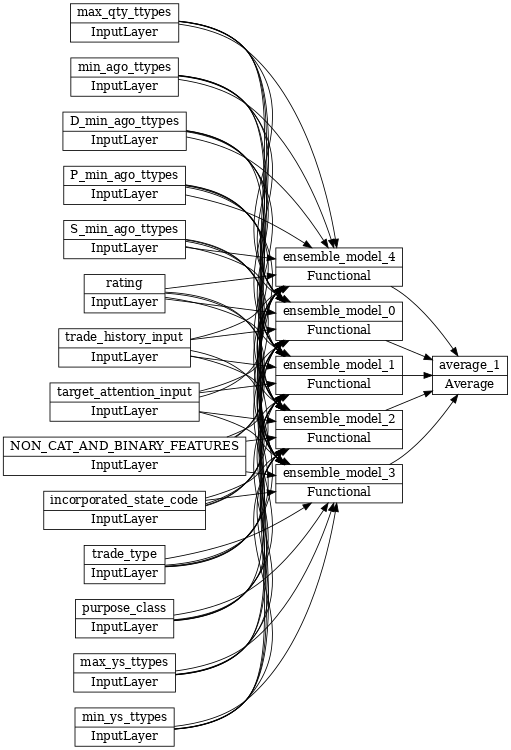

In [249]:
keras.utils.plot_model(ENSEMBLE_MODEL_COMMON_INPUT, rankdir='LR', dpi=60)

In [250]:
%time big_model_same_members_predictions = ENSEMBLE_MODEL_COMMON_INPUT.predict(x_test, batch_size=5000)

2023-08-15 16:54:19.413680: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-15 16:54:19.413831: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

CPU times: user 16.7 s, sys: 622 ms, total: 17.3 s
Wall time: 19.3 s


In [255]:
mean_absolute_error(test_dataframe.new_ys, big_model_same_members_predictions)

7.991395788770561

In [262]:
ENSEMBLE_MODEL_COMMON_INPUT.save(f'ensemble-{datetime.now().strftime("%m-%d")}')

INFO:tensorflow:Assets written to: ensemble-08-15/assets


INFO:tensorflow:Assets written to: ensemble-08-15/assets
/home/jupyter/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/jupyter/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Small Attempt at Fine-tuning

We can finetune at different levels of complexity: at one extreme, we just finetune the final dense layer that combines predictions, and at the other, we finetune the entire model. 


**Fine Tuning the last dense layer:**
1. There is little to no benefit from this. In fact, we see that the final layer eventually converges to almost equal weighting.

**Fine tuning all layers**:
1. Extremely slow, 1 epoch on training data is proportional to ensemble_size * time for 1 epoch on single model (see the training of a full model below to observe this longer training time per epoch)
2) In small epochs, it is detrimental to performance (unsurprisingly), even when we freeze the weights from earlier

In [178]:
x_train = create_input(train_dataframe, moodys = False)

In [194]:
model_input = ensemble_models[0].input
i = 0
m = 0 
model_outputs = []

for model in ensemble_models:
    model._name = 'ensemble_model_'+str(m)
    m+=1
    output = model(model_input)
    model_outputs.append(output)
    
ensemble_output = tf.keras.layers.Dense(1, name='final_output')(layers.concatenate(model_outputs, axis=-1))
ENSEMBLE_MODEL_COMMON_INPUT = keras.Model(inputs=model_input, outputs=ensemble_output)

In [203]:
temp_model = keras.models.clone_model(ENSEMBLE_MODEL_COMMON_INPUT)
temp_model.set_weights(ENSEMBLE_MODEL_COMMON_INPUT.get_weights())

In [204]:
for layer in temp_model.layers[:-1]:
    layer.trainable=False

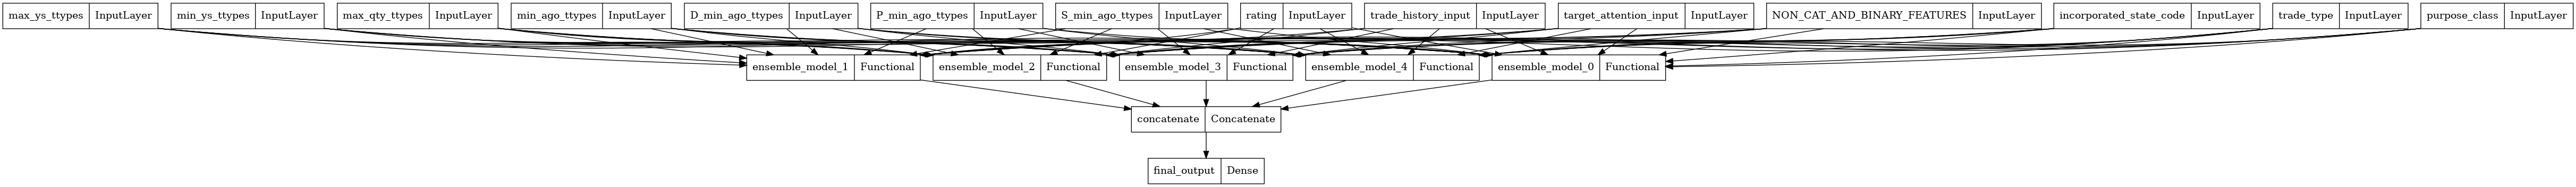

In [173]:
keras.utils.plot_model(temp_model)

In [174]:
y_train = train_dataframe[target_variable]

In [205]:
temp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002),
          loss=keras.losses.MeanAbsoluteError())

fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True)]

history= temp_model.fit(x_train,
                  y_train,
                    validation_split = 0.1,
                    epochs=25,     
                    verbose=1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8,
                 batch_size=5000)

Epoch 1/25


2023-08-14 21:27:48.802729: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-14 21:27:48.802996: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

605/605 [==============================] - ETA: 0s - loss: 21.8764

2023-08-14 21:28:36.916652: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-14 21:28:36.916818: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

605/605 [==============================] - 107s 83ms/step - loss: 21.8764 - val_loss: 10.1415
Epoch 2/25
605/605 [==============================] - 42s 70ms/step - loss: 9.9337 - val_loss: 8.8260
Epoch 3/25
605/605 [==============================] - 40s 66ms/step - loss: 9.8256 - val_loss: 8.8163
Epoch 4/25
605/605 [==============================] - 41s 68ms/step - loss: 9.7970 - val_loss: 8.8198
Epoch 5/25
605/605 [==============================] - 42s 70ms/step - loss: 9.7602 - val_loss: 8.8137
Epoch 6/25
605/605 [==============================] - 41s 68ms/step - loss: 9.7126 - val_loss: 8.8129
Epoch 7/25
605/605 [==============================] - 41s 67ms/step - loss: 9.6480 - val_loss: 8.8002
Epoch 8/25
605/605 [==============================] - 42s 70ms/step - loss: 9.5709 - val_loss: 8.7985
Epoch 9/25
605/605 [==============================] - 41s 68ms/step - loss: 9.4798 - val_loss: 8.7836
Epoch 10/25
605/605 [==============================] - 40s 66ms/step - loss: 9.3712 - val_

In [201]:
%time tuned_ensemble_predictions = temp_model.predict(x_test, batch_size=5000)
mean_absolute_error(test_dataframe.new_ys, tuned_ensemble_predictions)

2023-08-14 21:18:51.413424: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-14 21:18:51.413619: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

CPU times: user 15.2 s, sys: 2.86 s, total: 18.1 s
Wall time: 15.1 s


8.01438248749408

In [206]:
temp_model.layers[-1].get_weights()

[array([[0.1978369 ],
        [0.20616134],
        [0.20423597],
        [0.18899125],
        [0.20603296]], dtype=float32),
 array([-0.4499579], dtype=float32)]

### Training from scratch:
Here we test charles' idea to train an ensemble all at once with a high dropout. The goal here is the same as before: use high dropout to encourage different convergence in each model, but train together for simplicity. The preliminary results from tests so far are: 
1. Convergence is poor for the current set of hyperparameters
2. Training time is extrmely longer because more epochs needed, under current hyperparamters

In [244]:
model_input = ensemble_models[0].input
i = 0
m = 0 
model_outputs = []

for model in ensemble_models[:3]:
    model._name = 'ensemble_model_'+str(m)
    m+=1
    output = model(model_input)
    model_outputs.append(output)
    
ensemble_output = tf.keras.layers.Dense(1, name='final_output')(layers.concatenate(model_outputs, axis=-1))
ENSEMBLE_MODEL_COMMON_INPUT = keras.Model(inputs=model_input, outputs=ensemble_output)

In [245]:
temp_model = keras.models.clone_model(ENSEMBLE_MODEL_COMMON_INPUT)

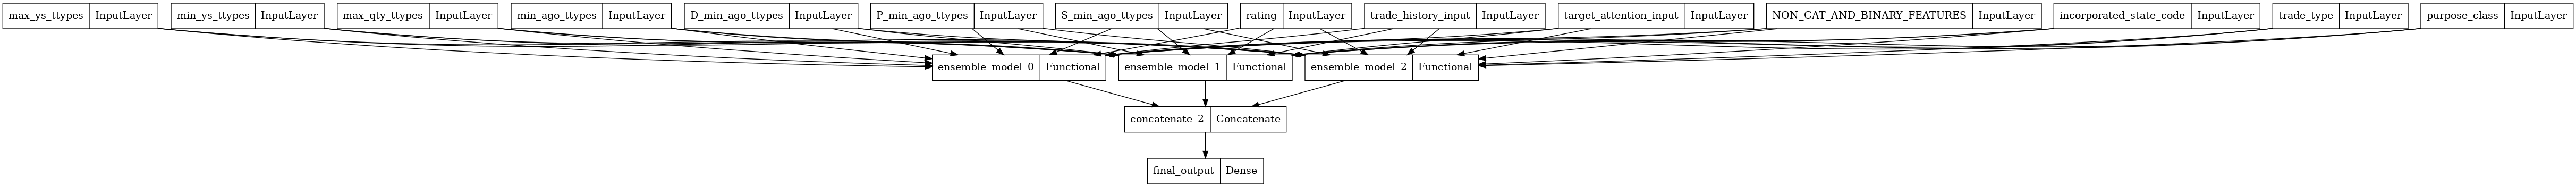

In [228]:
keras.utils.plot_model(temp_model)

In [246]:
temp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True)]

In [247]:
history= temp_model.fit(x_train,
                  y_train,
                    validation_split = 0.1,
                    epochs=75,     
                    verbose=1, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8,
                 batch_size=1000)

Epoch 1/75


2023-08-15 16:51:25.080553: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-15 16:51:25.080745: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

3025/3025 [==============================] - ETA: 0s - loss: 38.6993

2023-08-15 16:53:52.181954: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-15 16:53:52.182142: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

KeyboardInterrupt: 

In [242]:
%time tuned_ensemble_predictions = temp_model.predict(x_test, batch_size=5000)
mean_absolute_error(test_dataframe.new_ys, tuned_ensemble_predictions)

CPU times: user 5.51 s, sys: 1.51 s, total: 7.02 s
Wall time: 5.53 s


9.928058619313358

In [243]:
temp_model.layers[-1].get_weights()

[array([[ 0.8495041],
        [-1.3461872],
        [-1.3857007]], dtype=float32),
 array([0.8438705], dtype=float32)]